Loaded pretrained weights for efficientnet-b0


C:\Users\ajeet\AppData\Local\Temp\ipykernel_13012\466427298.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_b0.load_state_dict(torch.load('saved_models/Com


Matched: 39 / 50 (78.00%)
Mismatches (image, mask): [('depth_208_persp_right.png0001.png', 'render_208_persp_right_before_mask.png'), ('depth_216_persp_left.png0001.png', 'render_216_persp_left_before_mask.png'), ('depth_216_persp_right.png0001.png', 'render_216_persp_right_before_mask.png'), ('depth_217_persp_right.png0001.png', 'render_217_persp_right_before_mask.png'), ('depth_224_persp_right.png0001.png', 'render_224_persp_right_before_mask.png')] ...


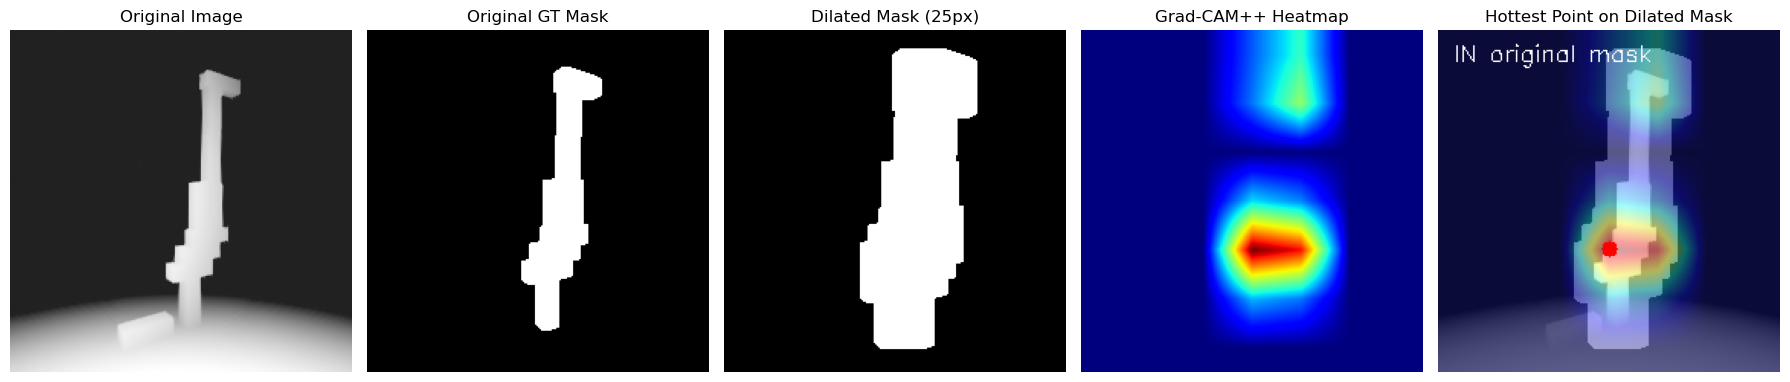

In [6]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet_b0._fc = torch.nn.Linear(efficientnet_b0._fc.in_features, 2)
efficientnet_b0.load_state_dict(torch.load('saved_models/Combined-DEPTH.pth'))
efficientnet_b0.to(device)
efficientnet_b0.eval()

target_layer = efficientnet_b0._conv_head
cam = GradCAMPlusPlus(model=efficientnet_b0, target_layers=[target_layer])

def get_hottest_point(cam):
    """Find the single hottest point in the CAM."""
    # Ensure CAM is properly normalized
    cam = np.maximum(cam, 0)  # ReLU equivalent
    cam = cam - np.min(cam)
    cam = cam / (np.max(cam) + 1e-8)  # Avoid division by zero
    
    # Find the single hottest point
    max_val = np.max(cam)
    max_indices = np.where(cam == max_val)
    
    # If multiple points have same max value, take the centroid
    if len(max_indices[0]) > 1:
        avg_y = int(np.mean(max_indices[0]))
        avg_x = int(np.mean(max_indices[1]))
        return (avg_y, avg_x)
    else:
        return (max_indices[0][0], max_indices[1][0])

dilate_pixels = 25  
dilation_kernel = np.ones((dilate_pixels, dilate_pixels), np.uint8) 

def check_point_in_mask(point, mask, dilated_mask=None):
    """Check if point is in original or dilated mask."""
    y, x = point
    if dilated_mask is not None:
        return (0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and 
                (mask[y, x] > 0 or dilated_mask[y, x] > 0))
    return 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x] > 0

img_dir = 'Test_Dataset/ColourTest3/Depth_Blender/Before'
mask_dir = 'Test_Dataset/ColourTest3/GTMasks'

image_paths = sorted(glob(os.path.join(img_dir, '*.*')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.*')))

assert len(image_paths) == len(mask_paths), "Mismatch in number of images and masks!"

match_count = 0
total_count = 0
mismatched_files = []

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Evaluating GradCAM peaks"):
    try:
        
        img = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(device)
        
        
        grayscale_cam = cam(input_tensor=input_tensor)[0]
        
        
        max_point = get_hottest_point(grayscale_cam)

        
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (224, 224))
        _, gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)
        dilated_mask = cv2.dilate(gt_mask, dilation_kernel, iterations=1)
        
        
        match = check_point_in_mask(max_point, gt_mask, dilated_mask)
        if match:
            match_count += 1
        else:
            mismatched_files.append((os.path.basename(img_path), os.path.basename(mask_path)))

        total_count += 1

    except Exception as e:
        print(f"Error with {img_path}: {e}")

# Report
print(f"\nMatched: {match_count} / {total_count} ({(match_count / total_count) * 100:.2f}%)")
if mismatched_files:
    print("Mismatches (image, mask):", mismatched_files[:5], "...")  # limit output

def visualize_pair(img_path, mask_path, grayscale_cam, max_point):
    # Load original RGB image
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    rgb_img = np.array(img_resized) / 255.0
    
    # Create CAM visualization
    cam_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # Load and process masks
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (224, 224))
    _, gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)
    dilated_mask = cv2.dilate(gt_mask, dilation_kernel, iterations=1)
    
    # Create visualization with max point on dilated mask
    dilated_rgb = cv2.cvtColor(dilated_mask, cv2.COLOR_GRAY2RGB)
    vis_img = cv2.addWeighted(cam_visualization, 0.7, dilated_rgb, 0.3, 0)
    
    if max_point is not None: 
        y, x = max_point
        cv2.circle(vis_img, (x, y), 5, (255, 0, 0), -1)  # Blue dot on max point
        # Add text showing if point is in original/dilated mask
        in_original = check_point_in_mask(max_point, gt_mask)
        in_dilated = check_point_in_mask(max_point, dilated_mask)
        status = ""
        if in_original:
            status = "IN original mask"
        elif in_dilated:
            status = "IN dilated mask (only)"
        else:
            status = "OUTSIDE both masks"
        cv2.putText(vis_img, status, (10, 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Plot all
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(rgb_img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Original GT Mask")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(dilated_mask, cmap='gray')
    plt.title(f"Dilated Mask ({dilate_pixels}px)")
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.title("Grad-CAM++ Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(vis_img)
    plt.title("Hottest Point on Dilated Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

i = 0  

img_path = image_paths[i]
mask_path = mask_paths[i]


img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0).to(device)

grayscale_cam = cam(input_tensor=input_tensor)[0]

max_point = get_hottest_point(grayscale_cam)

visualize_pair(img_path, mask_path, grayscale_cam, max_point)

In [8]:
def visualize_pair(img_path, mask_path, grayscale_cam, max_point):

    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    rgb_img = np.array(img_resized) / 255.0

    cam_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (224, 224))
    _, gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)
    dilated_mask = cv2.dilate(gt_mask, dilation_kernel, iterations=1)
 
    dilated_rgb = cv2.cvtColor(dilated_mask, cv2.COLOR_GRAY2RGB)
    vis_img = cv2.addWeighted(cam_visualization, 0.7, dilated_rgb, 0.3, 0)
    
    if max_point is not None:
        y, x = max_point
        cv2.circle(vis_img, (x, y), 5, (255, 0, 0), -1) 
 
        in_original = check_point_in_mask(max_point, gt_mask)
        in_dilated = check_point_in_mask(max_point, dilated_mask)
        status = ""
        if in_original:
            status = "IN original mask"
        elif in_dilated:
            status = "IN dilated mask (only)"
        else:
            status = "OUTSIDE both masks"
        cv2.putText(vis_img, status, (10, 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(rgb_img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Original GT Mask")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(dilated_mask, cmap='gray')
    plt.title(f"Dilated Mask ({dilate_pixels}px)")
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.title("Grad-CAM++ Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(vis_img)
    plt.title("Hottest Point on Dilated Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

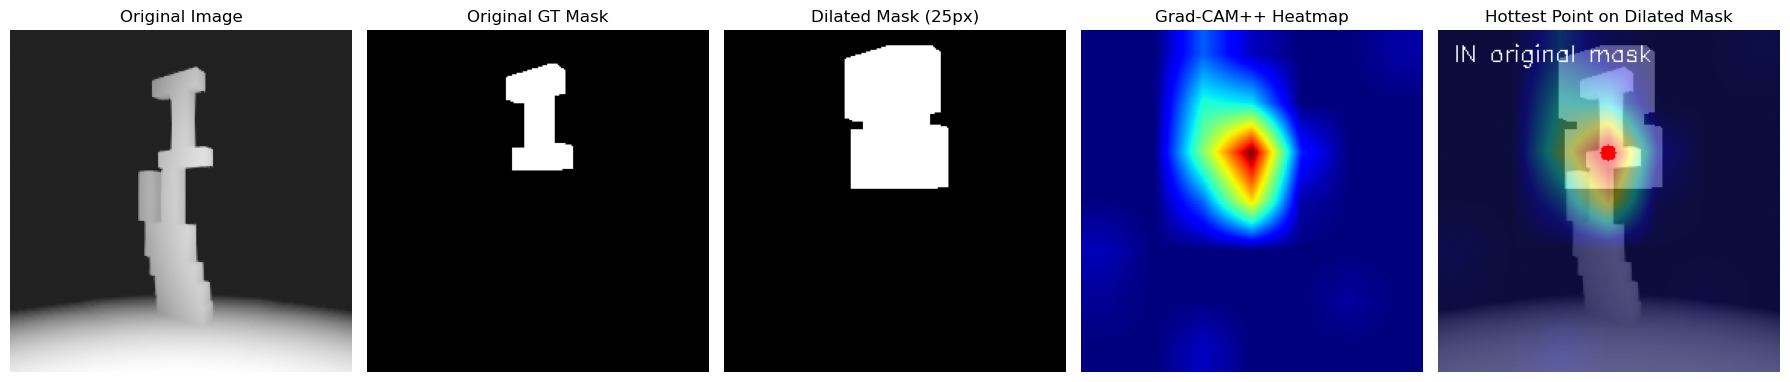

In [14]:

i = 45 

img_path = image_paths[i]
mask_path = mask_paths[i]

img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0).to(device)

grayscale_cam = cam(input_tensor=input_tensor)[0]

max_point = get_hottest_point(grayscale_cam)

visualize_pair(img_path, mask_path, grayscale_cam, max_point)